## Omics panel expansion using spaAnchor

In this section, we illustrate spaAnchor for omics panel expansion.

We use the Xenium obtained [human breast cancer dataset](https://www.10xgenomics.com/datasets/ffpe-human-breast-using-the-entire-sample-area-1-standard) for evaluation.
To test the model's panel expansion capabilities, we can simulate a common experimental scenario: predicting the unmeasured expression profile from a small panel of shared genes (<5% of the total features).
The function `sa.utils.assign_genes()` is designed for this purpose. It partitions the genes into a "shared" set and several "slice unique" sets.

In [1]:
import spaAnchor as sa
import scanpy as sc

adata0 = sc.read_h5ad('/mnt/sde/data/xenium/Xenium_V1_FFPE_Human_Breast_IDC_Big_1_outs.h5ad')
adata1 = sc.read_h5ad('/mnt/sde/data/xenium/Xenium_V1_FFPE_Human_Breast_IDC_Big_2_outs.h5ad')
gene_dict = sa.utils.assign_genes(adata0.var_names, 12, [134]*2)

After running the model, we return a Python dictionary containing the results. 
This dictionary is organized by slice, making it easy to access the predictions for each one.

The `prediction_result` variable holds this output, structured as follows:
- The top-level keys are the slice identifiers (e.g., 0 for slice 0).
- The value for each key is another dictionary containing the actual prediction data for that slice.

``` python
prediction_result = {
    # Key 0 corresponds to Slice 0
    0: {
        # The predicted expression for Slice 0's unique genes
        "X": pd.DataFrame,
        ... # Other predicted features for this slice, if any
    },
    # Key 1 would contain results for Slice 1, and so on...
    1: { ... },
    ...
}
```
To access the predicted gene expression result for slice 0, you would use `prediction_result[0]["X"]`.

In [2]:
model = sa.panel_expansion()
predicted_result = model([
    adata0[:, gene_dict['shared_genes']+gene_dict['slice_0']].copy(), 
    adata1[:, gene_dict['shared_genes']+gene_dict['slice_1']].copy()
])

INFO: Finish preprocessing. (5.702s)
INFO: Generate 3,101,741 edges, average 3.500 edges per cell.
INFO: Generate 3,075,188 edges, average 3.500 edges per cell.
INFO: Finish latent embedding generating. (16.857s)
INFO: Finish HANN pairs finding. (295.625s)


INFO: Learn aggregate attention score: 100%|██████████| 500/500 [00:24<00:00, 20.07it/s]


INFO: Finish transformation. (83.850s)


User can further assess the model's performance by comparing the predicted expression of a key gene, like *ERBB2*, against its measured value. 

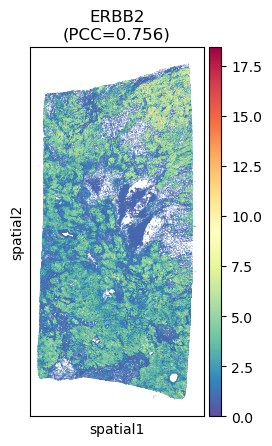

In [3]:
from scipy.stats import pearsonr
adata0.obs_names += f"-0"
result_adata0 = adata0[predicted_result[0]["X"].index]
result_adata0.obs["pred_ERBB2"] = predicted_result[0]["X"]["ERBB2"]
pcc = pearsonr(result_adata0[:, "ERBB2"].X.toarray().T[0], result_adata0.obs["pred_ERBB2"])[0]
sc.pl.spatial(result_adata0, color=["pred_ERBB2"], cmap="Spectral_r", 
              title=f"ERBB2\n(PCC={pcc:.3f})",
              library_id=None, spot_size=3)